ЛР3 решающие деревья для Phishing Websites и CCPP (заводы)


In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, RepeatedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay,
    mean_absolute_error, r2_score, root_mean_squared_error
)
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import warnings
warnings.filterwarnings('ignore')
RANDOM_STATE = 1204
np.random.seed(RANDOM_STATE)


Загружаем Phishing с OpenML и готовим признаки и цель, потому что так корректно считаются метрики и выполняется стратифицированный сплит

In [8]:
ds = fetch_openml(data_id=4534, as_frame=True)
df = ds.frame.copy()
y_cls = (df['Result'].astype(int) == 1).astype(int).to_numpy()
X_cls = df.drop(columns=['Result']).replace('?', np.nan).apply(pd.to_numeric, errors='coerce')
Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    X_cls, y_cls, test_size=0.2, random_state=RANDOM_STATE, stratify=y_cls
)
print('Баланс train:', np.unique(yc_train, return_counts=True))
print('Баланс test :', np.unique(yc_test, return_counts=True))


Баланс train: (array([0, 1]), array([3918, 4926], dtype=int64))
Баланс test : (array([0, 1]), array([ 980, 1231], dtype=int64))


Данные для регрессии Combined Cycle Power Plant CCPP

Читаем таблицу Folds5x2_pp.xlsx где целевой признак PE это выходная мощность а остальные переменные входные факторы среды

In [9]:
reg_path = '../datasets/Folds5x2_pp.xlsx'
try:
    df_reg = pd.read_excel(reg_path)
except FileNotFoundError:
    raise FileNotFoundError("Поместите рядом файл Folds5x2_pp.xlsx")
y_reg = df_reg['PE'].to_numpy()
X_reg = df_reg.drop(columns=['PE'])
Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=RANDOM_STATE
)
print('Размеры регрессии:', Xr_train.shape, Xr_test.shape)


Размеры регрессии: (7654, 4) (1914, 4)


Строим базовое дерево для классификации с импьютацией пропусков и считаем метрики: Accuracy, Macro‑F1 и ROC‑AUC

Бейзлайн классификация: {'Accuracy': 0.9710538218000905, 'MacroF1': 0.9706447597709733, 'ROC-AUC': 0.9804522621396243}


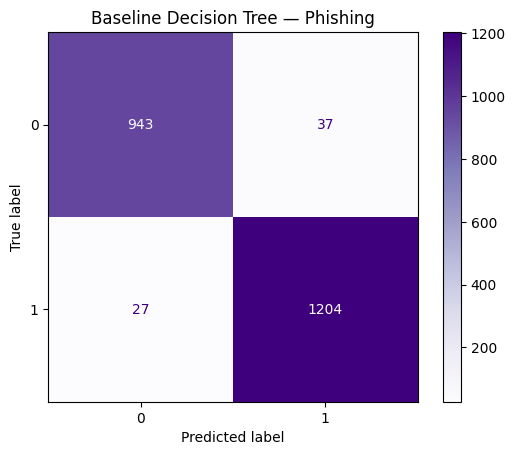

In [10]:
pipe_dt_cls_base = Pipeline([
    ('imp', SimpleImputer(strategy='most_frequent')),
    ('dt', DecisionTreeClassifier(random_state=RANDOM_STATE))
])
pipe_dt_cls_base.fit(Xc_train, yc_train)
yc_pred = pipe_dt_cls_base.predict(Xc_test)
yc_proba = pipe_dt_cls_base.predict_proba(Xc_test)[:, 1]
base_cls = {
    'Accuracy': accuracy_score(yc_test, yc_pred),
    'MacroF1': f1_score(yc_test, yc_pred, average='macro'),
    'ROC-AUC': roc_auc_score(yc_test, yc_proba)
}
print('Бейзлайн классификация:', base_cls)
cm = confusion_matrix(yc_test, yc_pred, labels=[0, 1])
ConfusionMatrixDisplay(cm, display_labels=[0, 1]).plot(cmap='Purples')
plt.title('Baseline Decision Tree — Phishing')
plt.show()


Строим базовое дерево для регрессии и сравниваем RMSE, MAE и R2

Бейзлайн регрессия: {'RMSE': 4.415174152897932, 'MAE': 3.0093312434691737, 'R2': 0.9327935649059674}


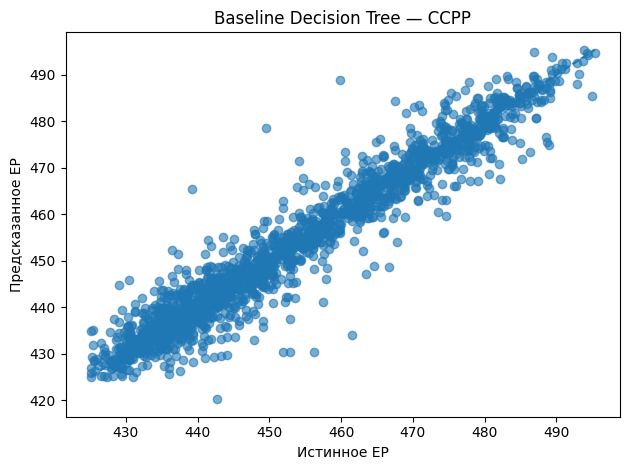

In [11]:
pipe_dt_reg_base = Pipeline([
    ('dt', DecisionTreeRegressor(random_state=RANDOM_STATE))
])
pipe_dt_reg_base.fit(Xr_train, yr_train)
yr_pred = pipe_dt_reg_base.predict(Xr_test)
base_reg = {
    'RMSE': root_mean_squared_error(yr_test, yr_pred),
    'MAE': mean_absolute_error(yr_test, yr_pred),
    'R2': r2_score(yr_test, yr_pred)
}
print('Бейзлайн регрессия:', base_reg)
plt.figure()
plt.scatter(yr_test, yr_pred, alpha=0.6)
plt.xlabel('Истинное EP')
plt.ylabel('Предсказанное EP')
plt.title('Baseline Decision Tree — CCPP')
lo, hi = float(np.min(yr_test)), float(np.max(yr_test))
plt.plot([lo, hi], [lo, hi], linestyle='--')
plt.tight_layout()
plt.show()


Тюним критерий, глубину и размеры узлов по Macro‑F1 на повторной стратифицированной CV для классификации, используя рандомизированную сетку kfolds

Fitting 3 folds for each of 1250 candidates, totalling 3750 fits
Improved (Randomized) classification: {'Accuracy': 0.9719583898688376, 'MacroF1': 0.9715621110281305, 'ROC-AUC': 0.982610371524727}
Best params (cls): {'dt__ccp_alpha': 1.4397787969032083e-05, 'dt__class_weight': 'balanced', 'dt__criterion': 'gini', 'dt__max_depth': 24, 'dt__max_features': 0.5, 'dt__min_samples_leaf': 1, 'dt__min_samples_split': 2}


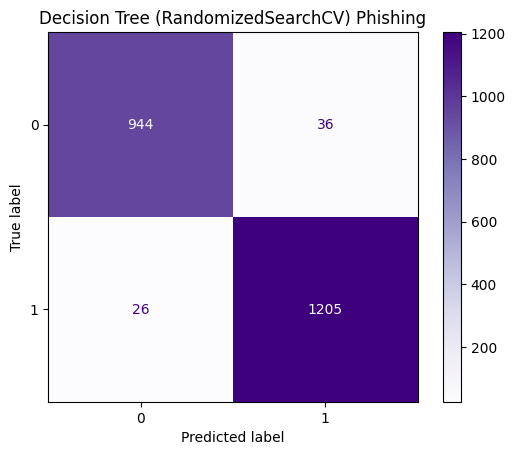

In [39]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import randint, uniform, loguniform
import numpy as np
import matplotlib.pyplot as plt

pipe_dt_cls = Pipeline([
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("dt", DecisionTreeClassifier(random_state=42))
])

# Распределения гиперпараметров для рандСерча
param_dist_c = {
    "dt__criterion": ["gini", "entropy", "log_loss"],      
    "dt__max_depth": randint(3, 36),               
    "dt__min_samples_split": randint(2, 36),               
    "dt__min_samples_leaf": randint(1, 36),               
    "dt__max_features": [None, "sqrt", "log2", 0.5],      
    "dt__class_weight": [None, "balanced"],                
    "dt__ccp_alpha": loguniform(1e-5, 1e-2)                
}

cv_c = StratifiedKFold(n_splits=3, shuffle=True, random_state=105)

rs_cls = RandomizedSearchCV(
    estimator=pipe_dt_cls,
    param_distributions=param_dist_c,
    #Ограничиваем сверху число итерацй
    n_iter=1250,                  
    scoring="f1_macro",
    n_jobs=-1,
    cv=cv_c,
    random_state=42,
    refit=True,
    verbose=1
)

rs_cls.fit(Xc_train, yc_train)

y_pred = rs_cls.predict(Xc_test)
y_proba = rs_cls.predict_proba(Xc_test)[:, 1]

imp_cls = {
    "Accuracy": accuracy_score(yc_test, y_pred),
    "MacroF1": f1_score(yc_test, y_pred, average="macro"),
    "ROC-AUC": roc_auc_score(yc_test, y_proba)
}
print("Improved (Randomized) classification:", imp_cls)
print("Best params (cls):", rs_cls.best_params_)

cm = confusion_matrix(yc_test, y_pred, labels=[0, 1])
ConfusionMatrixDisplay(cm, display_labels=[0, 1]).plot(cmap="Purples")
plt.title("Decision Tree (RandomizedSearchCV) Phishing")
plt.show()


Тюним глубину, критерий и размеры узлов по RMSE на повторной CV для регрессии

Улучшенная регрессия: {'RMSE': 3.946261757502419, 'MAE': 2.908347636872399, 'R2': 0.9463107966776645}
Лучшие параметры (reg): {'dt__criterion': 'friedman_mse', 'dt__max_depth': 10, 'dt__max_features': None, 'dt__min_samples_leaf': 10, 'dt__min_samples_split': 2}


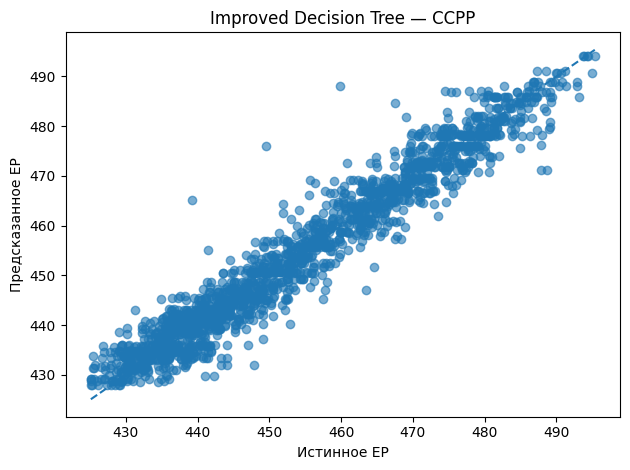

In [13]:
cv_r = RepeatedKFold(n_splits=5, n_repeats=2, random_state=RANDOM_STATE)
pipe_dt_reg = Pipeline([
    ('dt', DecisionTreeRegressor(random_state=RANDOM_STATE))
])
grid_r = {
    'dt__criterion': ['squared_error', 'friedman_mse', 'absolute_error'],
    'dt__max_depth': [None, 4, 6, 10, 16, 24],
    'dt__min_samples_split': [2, 5, 10, 20],
    'dt__min_samples_leaf': [1, 2, 5, 10],
    'dt__max_features': [None, 'sqrt', 'log2']
}
gs_dt_r = GridSearchCV(
    estimator=pipe_dt_reg,
    param_grid=grid_r,
    scoring='neg_root_mean_squared_error',
    cv=cv_r,
    n_jobs=-1,
    refit=True
)
gs_dt_r.fit(Xr_train, yr_train)
yr1 = gs_dt_r.predict(Xr_test)
imp_reg = {
    'RMSE': root_mean_squared_error(yr_test, yr1),
    'MAE': mean_absolute_error(yr_test, yr1),
    'R2': r2_score(yr_test, yr1)
}
print('Улучшенная регрессия:', imp_reg)
print('Лучшие параметры (reg):', gs_dt_r.best_params_)
plt.figure()
plt.scatter(yr_test, yr1, alpha=0.6)
plt.xlabel('Истинное EP')
plt.ylabel('Предсказанное EP')
plt.title('Improved Decision Tree CCPP')
lo, hi = float(np.min(yr_test)), float(np.max(yr_test))
plt.plot([lo, hi], [lo, hi], linestyle='--')
plt.tight_layout()
plt.show()


Сравниваем базовые и улучшенные модели по ключевым метрикам

In [33]:
cmp_cls = pd.DataFrame([
    {'Model': 'Baseline', **base_cls},
    {'Model': 'Improved', **imp_cls}
]).set_index('Model').round(4)
cmp_reg = pd.DataFrame([
    {'Model': 'Baseline', **base_reg},
    {'Model': 'Improved', **imp_reg}
]).set_index('Model').round(4)
display(cmp_cls)
display(cmp_reg)


,Accuracy,MacroF1,ROC-AUC
Model,,,
Baseline,0.9711,0.9706,0.9805
Improved,0.9738,0.9734,0.9817


,RMSE,MAE,R2
Model,,,
Baseline,4.4152,3.0093,0.9328
Improved,3.9463,2.9083,0.9463


Ручная имплементация для классификации
Делаем простой decision stump с глубиной 1 на gini для наглядного бенчмарка

In [15]:
def gini_impurity(y):
    if y.size == 0:
        return 0.0
    p = float(y.mean())
    return 2 * p * (1 - p)

def best_stump_split(X, y, n_splits=50):
    Xv = np.asarray(X.values if isinstance(X, pd.DataFrame) else X, dtype=float)
    yv = y.astype(int)
    n, p = Xv.shape
    best = {'feat': None, 'thr': None, 'gini': 1.0}
    for j in range(p):
        col = Xv[:, j]
        if np.isnan(col).any():
            col = np.nan_to_num(col, nan=np.nanmedian(col))
        lo, hi = np.percentile(col, [1, 99])
        if lo == hi:
            continue
        thresholds = np.linspace(lo, hi, n_splits)
        for t in thresholds:
            left = yv[col <= t]
            right = yv[col > t]
            g = (left.size * gini_impurity(left) + right.size * gini_impurity(right)) / max(1, yv.size)
            if g < best['gini']:
                best = {'feat': j, 'thr': float(t), 'gini': float(g)}
    return best

def stump_predict(X, feat, thr):
    Xv = np.asarray(X.values if isinstance(X, pd.DataFrame) else X, dtype=float)
    col = Xv[:, feat]
    col = np.nan_to_num(col, nan=np.nanmedian(col))
    return (col > thr).astype(int)

best = best_stump_split(Xc_train, yc_train)
ys = stump_predict(Xc_test, best['feat'], best['thr'])
scratch_cls = {
    'Accuracy': accuracy_score(yc_test, ys),
    'MacroF1': f1_score(yc_test, ys, average='macro'),
    'ROC-AUC': roc_auc_score(yc_test, ys)
}
print('С нуля классификация (stump):', scratch_cls)
print('Лучший признак и порог:', best)


С нуля классификация (stump): {'Accuracy': 0.8887381275440976, 'MacroF1': 0.8866936149150305, 'ROC-AUC': 0.8848928198411777}
Лучший признак и порог: {'feat': 7, 'thr': 0.020408163265306145, 'gini': 0.19740961320689762}


Ручная реализация для регрессии: stump выбирает признак и порог по минимуму внутрикластерной дисперсии по MSE

In [16]:
def best_stump_split_reg(X, y, n_splits=50):
    Xv = np.asarray(X.values if isinstance(X, pd.DataFrame) else X, dtype=float)
    yv = y.astype(float)
    n, p = Xv.shape
    best = {'feat': None, 'thr': None, 'mse': np.inf}
    for j in range(p):
        col = Xv[:, j]
        if np.isnan(col).any():
            col = np.nan_to_num(col, nan=np.nanmedian(col))
        lo, hi = np.percentile(col, [1, 99])
        if lo == hi:
            continue
        thresholds = np.linspace(lo, hi, n_splits)
        for t in thresholds:
            left = yv[col <= t]
            right = yv[col > t]
            if left.size == 0 or right.size == 0:
                continue
            mse = left.var() * left.size + right.var() * right.size
            if mse < best['mse']:
                best = {'feat': j, 'thr': float(t), 'mse': float(mse)}
    return best

def stump_predict_reg(X, feat, thr, y_train, X_train):
    Xv = np.asarray(X.values if isinstance(X, pd.DataFrame) else X, dtype=float)
    Xtr = np.asarray(X_train.values if isinstance(X_train, pd.DataFrame) else X_train, dtype=float)
    col_te = np.nan_to_num(Xv[:, feat], nan=np.nanmedian(Xv[:, feat]))
    col_tr = np.nan_to_num(Xtr[:, feat], nan=np.nanmedian(Xtr[:, feat]))
    left_idx_tr = col_tr <= thr
    right_idx_tr = col_tr > thr
    left_pred = float(np.mean(y_train[left_idx_tr]))
    right_pred = float(np.mean(y_train[right_idx_tr]))
    return np.where(col_te <= thr, left_pred, right_pred)

best_r = best_stump_split_reg(Xr_train, yr_train)
yrs = stump_predict_reg(Xr_test, best_r['feat'], best_r['thr'], yr_train, Xr_train)
scratch_reg = {
    'RMSE': root_mean_squared_error(yr_test, yrs),
    'MAE': mean_absolute_error(yr_test, yrs),
    'R2': r2_score(yr_test, yrs)
}
print('С нуля регрессия (stump):', scratch_reg)
print('Лучший признак и порог (reg):', best_r)


С нуля регрессия (stump): {'RMSE': 9.016055005926422, 'MAE': 7.409239802727366, 'R2': 0.7197482796552029}
Лучший признак и порог (reg): {'feat': 0, 'thr': 17.718710204081635, 'mse': 622871.588979898}


Сводим метрики для оценки прироста качества после так называемого тюнинга)

In [40]:
cmp_cls_all = pd.DataFrame([
    {'Model': 'Baseline', **base_cls},
    {'Model': 'Improved', **imp_cls},
    {'Model': 'Scratch', **scratch_cls}
]).set_index('Model').round(4)
cmp_reg_all = pd.DataFrame([
    {'Model': 'Baseline', **base_reg},
    {'Model': 'Improved', **imp_reg},
    {'Model': 'Scratch', **scratch_reg}
]).set_index('Model').round(4)
display(cmp_cls_all)
display(cmp_reg_all)


,Accuracy,MacroF1,ROC-AUC
Model,,,
Baseline,0.9711,0.9706,0.9805
Improved,0.9720,0.9716,0.9826
Scratch,0.8887,0.8867,0.8849


,RMSE,MAE,R2
Model,,,
Baseline,4.4152,3.0093,0.9328
Improved,3.9463,2.9083,0.9463
Scratch,9.0161,7.4092,0.7197


Вывод: у деревьев качество заметно растёт после подбора глубины, а одноузловые stump модели ожидаемо отстают и служат простым ориентиром без заоблачных метрик